<a href="https://colab.research.google.com/github/PedroDS4/Sampling_and_correlation_in_a_comunication_system/blob/main/Amostragem_e_correla%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Amostragem e Sincronização por Correlação**

### **Matemática da Transmissão**
**Codificação**
A codificação é o ato de transformar os caracteres em string que irão ser transmitidos em bits, por exemplo

$$
"A"  -> 0100 0001
$$

$$
"B"  -> 0100 0010
$$

essa conversão pode ser encontrada diretamente na tabela ASCII, e existem funções que ja fazem essa conversão.


Então seja uma sequência a ser transmitida, como por exemplo abaixo

$$
Str = "Olá \ mundo"
$$

Quando codificada, gera-se um vetor com os bits dos símbolos, que depois irá ser convertido em números únicos

$$
s = letrapam(str)
$$

O tipo de codificação será uma 4-PAM
dada pela relação

00 -> -3

01 -> -1

10 ->  1

11 -> 3



**Filtro de pulso**
Depois da codificação, os símbolos dos caracteres precisam ser armazenados em um vetor, para serem transformados em um sinal analógico.

Esse vetor em que os simbolos são adicionados, pode ser representado por um trem de impulsos, dado por

$$
s[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM]
$$


e esse sinal de simbolos é convoluído com uma forma de pulso, $p[n]$, e o sinal resultante que será transmitido, fica

$$
x[n] = s[n] \ast p[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM] \ast p[n]
$$

então

$$
x[n] =  \sum_{k = 0}^{M} s_k \cdot (p[n] \ast \delta[n-kM]) = \sum_{k = 0}^{M} s_k p[n - kM]
$$

e o sinal $x[n]$ é passado por um conversor D/A para a modulação e posteriormente transmissão.


##**Canal**
Depois de sair do transmissor, o sinal chega ao receptor apresentando algumas distorções de canal

**Ruído aditivo**
O ruído aditivo é a modelagem mais simplificada de um efeito de canal, onda o sinal é somado a um sinal de ruído aleatório gerado, Matematicamente temos

$$
x_{recebido}(t) = x(t) + \eta (t)
$$




###**Sincronização por correlação**
A operação de correlação é feita de modo a aumentar a relação sinal ruído do sinal que é recebido, que normalmente está contaminado com ruído aditivo.

A correlação entre dois sinais é dada por

$$
\phi_{xy} = \sum_{k = -∞ }^{∞} x[k] y[n + k]
$$


que também pode ser vista como uam convolução entre o sinal x e o sinal y refletido, uma vez que

$$
\sum_{k = -∞ }^{∞} x[k] y[n + k] = \sum_{k = -∞ }^{∞} x[k] y[-(-n - k)]
$$

e se temos

$$
y_r[n] = y[-n]
$$

então

$$
\phi_{xy} = \sum_{k = -∞ }^{∞} x[k] y_r[n - k] = x[n] \ast y[-n]
$$

muitas vezes a sincronização é implementada assim, e essa implementação também pode ser chamada de filtro casado(Match Filter).

No contexto dos sistemas de comunicações, a operação de correlação é utilizada para aumentar a relação sinal ruído do sinal recebido, para evitar erros na mensagem transmitida.

Seja o sinal recebido com ruído aditivo de canal dado por

$$
x_r[n] = x[n] + \eta[n]
$$

é então feita a correlação do sinal recebido com o filtro de pulso usado para transformar a mensagem em um sinal banda base, temos então

$$
y[n] = correlacao(x_r[n],p[n]) = \sum_{m = 0}^{N-1} x_r[n] p[n + m]
$$

porém temos ainda que

$$
x_r[n] = x[n] + \eta[n]
$$

e

$$
x[n] = s[n] \ast p[n]
$$

então temos

$$
y[n] = \sum_{m = 0}^{N-1} (s[n] \ast p[n] + \eta[n] ) p[n + m]
$$

distribuindo

$$
y[n] = \sum_{m = 0}^{N-1} (s[n] \ast p[n] ) p[n + m] +  \sum_{m = 0}^{N-1}  \eta[n] p[n + m]
$$

e normalmente o ruído é descorrelacionado com o sinal, assim a parcela de ruído se torna muito próxima de zero, então


$$
y[n] = \sum_{m = 0}^{N-1} (s[n] \ast p[n] ) p[n + m]
$$

porém é possível perceber que precisamos normalizar ainda o sinal $y[n]$ de acordo com a potência do pulso para que as amplitudes originais se revelem, então

$$
y_{normalizado}[n] = \frac{y[n]}{ E\{\ p[n]^2 \}\ }
$$

porém se a correlação e a convolução são truncadas para o mesmo tamanho do sinal $x[n]$, o sinal $y[n]$ tem o mesmo tamanho que ele, então basta fazermos uma sobreamostragem do sinal(diminuir sua frequência de amostragem), para que consigamos pegar os picos da correlação que correspondem a amplitude dos simbolos.
então o vetor de simbolos recebido finalmente é dado por

$$
s_r[n] = y_{normalizado}[n/M]
$$

para todo $n = kM$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal.windows import hamming

# Funções importantes do transmissor
def letrapam(string):
    # Codifica uma string usando 4-PAM
    # string: A string a ser codificada.
    # symbols: Vetor de símbolos 4-PAM codificados.

    # Converte a string em uma sequência de bits
    bits = ''.join(format(ord(c), '08b') for c in string)

    # Mapeia os bits para símbolos 4-PAM
    symbols = []
    for i in range(0, len(bits), 2):
        dibits = bits[i:i+2]
        if dibits == '00':
            symbols.append(-3)
        elif dibits == '01':
            symbols.append(-1)
        elif dibits == '10':
            symbols.append(1)
        elif dibits == '11':
            symbols.append(3)

    return np.array(symbols)

def pamdecod(symbols):
    # Decodifica símbolos 4-PAM em uma string
    # symbols: Vetor de símbolos 4-PAM.
    # string: A string decodificada.

    # Mapeia os símbolos 4-PAM de volta para bits
    bits = ''.join(
        '00' if symbol == -3 else
        '01' if symbol == -1 else
        '10' if symbol == 1 else
        '11' for symbol in symbols
    )

    # Converte a sequência de bits de volta para uma string
    string = ''.join(
        chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8)
    )
    return string

def quantizador(x, niveis):
    # Quantiza um sinal com base em níveis fornecidos
    # x: Sinal de entrada.
    # niveis: Vetor de níveis de quantização.
    # x_q: Sinal quantizado.

    x_q = np.zeros(len(x))
    for i in range(len(x)):
        e = np.abs(niveis - x[i])
        x_q[i] = niveis[np.argmin(e)]

    return x_q



import numpy as np


def xcorr(x, y, maxlags=None, normed=True, detrend=None):
    # Detrend the data if a detrend function is provided
    if detrend:
        x = detrend(x)
        y = detrend(y)

    # Compute the cross-correlation
    corr = np.correlate(x, y, mode='full')

    # Normalize if required
    if normed:
        corr /= np.sqrt(np.sum(x**2) * np.sum(y**2))

    # Limit the lags if maxlags is specified
    if maxlags is not None:
        center = len(corr) // 2
        start = center - maxlags // 2
        end = center + maxlags // 2 + 1
        corr = corr[start:end]

    return corr


##**Ambiente de Simulação do Sistema**

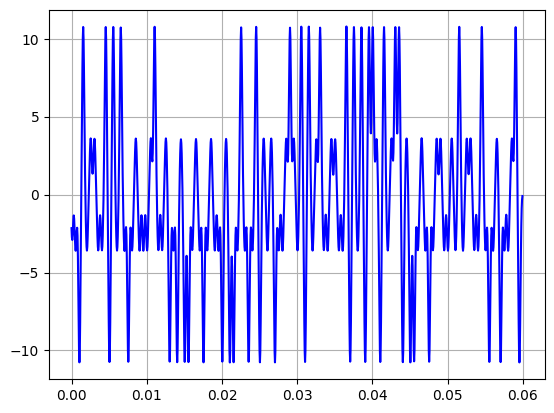

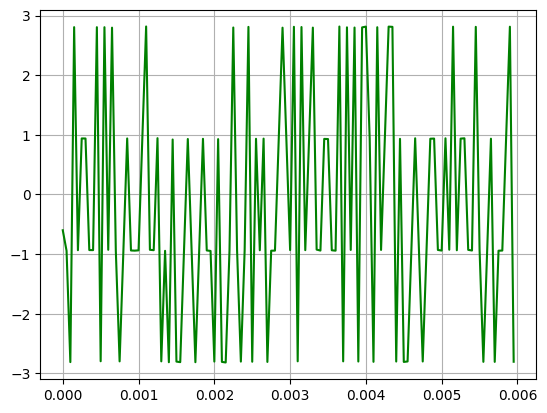

Mensagem original: Sistema de transmissão digital
Mensagem codificada: [-1 -1 -3  3 -1  1  1 -1 -1  3 -3  3 -1  3 -1 -3 -1  1 -1 -1 -1  1  3 -1
 -1  1 -3 -1 -3  1 -3 -3 -1  1 -1 -3 -1  1 -1 -1 -3  1 -3 -3 -1  3 -1 -3
 -1  3 -3  1 -1  1 -3 -1 -1  1  3  1 -1  3 -3  3 -1  1  3 -1 -1  1  1 -1
 -1  3 -3  3 -1  3 -3  3  3  1 -3  3 -1  1  3  3 -3  1 -3 -3 -1  1 -1 -3
 -1  1  1 -1 -1  1 -1  3 -1  1  1 -1 -1  3 -1 -3 -1  1 -3 -1 -1  1  3 -3]
Mensagem quantizada: [-1. -1. -3.  3. -1.  1.  1. -1. -1.  3. -3.  3. -1.  3. -1. -3. -1.  1.
 -1. -1. -1.  1.  3. -1. -1.  1. -3. -1. -3.  1. -3. -3. -1.  1. -1. -3.
 -1.  1. -1. -1. -3.  1. -3. -3. -1.  3. -1. -3. -1.  3. -3.  1. -1.  1.
 -3. -1. -1.  1.  3.  1. -1.  3. -3.  3. -1.  1.  3. -1. -1.  1.  1. -1.
 -1.  3. -3.  3. -1.  3. -3.  3.  3.  1. -3.  3. -1.  1.  3.  3. -3.  1.
 -3. -3. -1.  1. -1. -3. -1.  1.  1. -1. -1.  1. -1.  3. -1.  1.  1. -1.
 -1.  3. -1. -3. -1.  1. -3. -1. -1.  1.  3. -3.]
Mensagem decodificada: Sistema de transmissão digital


In [ ]:
# Transmissão

# Codificação
mensagem = 'Sistema de transmissão digital'
s = letrapam(mensagem)
N = len(s)
M = 10
mup = np.zeros(N * M)
for i in range(N):
    mup[i * M] = s[i]


# Filtro de formato de pulso
p_hamming = hamming(M)

# Filtragem com o filtro de pulso
x = convolve(mup, p_hamming, mode='same')
Ts = 1 / 20000  # Definição do período de amostragem (ajuste conforme necessário)
t_x = np.arange(len(x)) * Ts


# Canal
# Efeito de canal de ruído aditivo simples

x = x + 0.01*np.random.randn(len(x))






# Recepção Ideal Simples
# Correlação
# y = np.correlate(x, p_hamming, mode='same')

# Correlação implementada por convolução com Filtro casado
y = np.convolve(x,p_hamming[::-1],"same")

t_y = np.arange(len(y)) * Ts



# Visualizar o sinal de correlação
plt.figure()
plt.plot(t_y, y, 'b')
plt.grid(True)
plt.show()


# Decimação para pegar os picos da correlação seguida de normalização
z = y[0::M] / np.sum(p_hamming ** 2)
t_z = np.arange(len(z)) * Ts

# Visualizar o sinal após decimação
plt.figure()
plt.plot(t_z, z, 'green')
plt.grid(True)
plt.show()

# Quantização
niveis = np.array([-3, -1, 1, 3])
m_prime = quantizador(z, niveis)

print(f"Mensagem original: {mensagem}")
print(f"Mensagem codificada: {s}")
print(f"Mensagem quantizada: {m_prime}")

# Decodificação
string_rec = pamdecod(m_prime)
print(f"Mensagem decodificada: {string_rec}")